In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from glob import glob

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sbibm
from sbi import analysis as analysis
from sbibm.utils.io import get_tensor_from_csv

In [3]:
def get_training_samples_id(path: str):
    directory_name = path.split("/")[-1]
    training_samples_id = directory_name.split("_")[-1]
    return int(training_samples_id)

In [4]:
df = pd.read_csv("metrics.csv", index_col=0)
df["training_samples_id"] = df["training_samples_root"].map(get_training_samples_id)
df.head()

,task,num_simulations,num_observation,seed,max_num_epochs,algorithm,num_atoms,gamma,training_samples_root,C2ST,C2ST_Z,MMD,MMD_Z,MEDDIST,NLTP,RT,num_simulations_simulator,path,folder,training_samples_id
0,two_moons,100000,1,1833937892,300,CNRE,10,1.00,training-data/02,0.51775,0.57615,0.000020,0.000020,0.093374,NaN,51.995451,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,49,2
1,slcp,100000,1,3174243131,300,CNRE,2,0.33,training-data/04,0.87670,0.87280,0.021014,0.028741,19.427849,NaN,21.511070,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,103,4
2,two_moons,100000,1,3870525032,300,CNRE,2,1.33,training-data/04,0.67065,0.69750,0.014787,0.014788,0.088200,NaN,43.444279,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,15,4
3,slcp,100000,1,2024047962,300,CNRE,2,1.00,training-data/01,0.95925,0.95815,0.046334,0.201310,20.568804,NaN,83.035563,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,108,1
4,slcp,100000,1,1741751193,300,CNRE,2,0.33,training-data/02,0.93340,0.93110,0.037407,0.061683,20.513710,NaN,47.585323,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,101,2


In [8]:
df["task"].unique()

array(['two_moons', 'slcp'], dtype=object)

In [5]:
df["gamma"].unique()

array([1.  , 0.33, 1.33, 0.66, 1.66,  nan])

## cnre

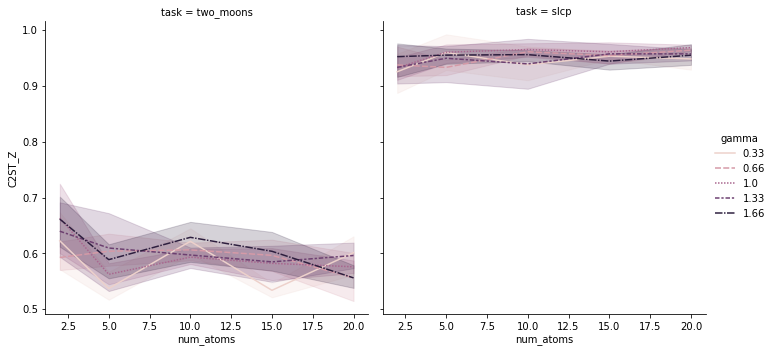

In [16]:
dfcnre = df[df["algorithm"] == "CNRE"]
sns.relplot(
    data=dfcnre, 
    x="num_atoms", 
    y="C2ST_Z", 
    style="gamma", 
    # hue="algorithm", 
    hue="gamma",
    col="task",
    kind="line",
)

## num atoms

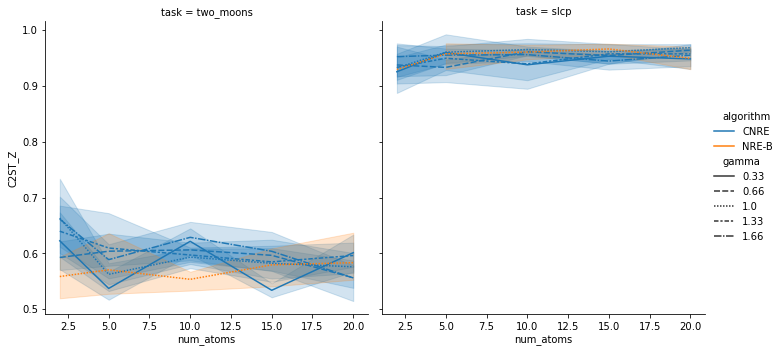

In [7]:
sns.relplot(
    data=df.fillna(1.0), 
    x="num_atoms", 
    y="C2ST_Z", 
    style="gamma", 
    hue="algorithm", 
    col="task",
    kind="line",
    # row="task",
)